<a href="https://colab.research.google.com/github/theresiasns/Aplikasi-Login/blob/main/Paddy_Disease_Good_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.2 MB/s eta 0:00:00


In [ ]:
pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
base_dir="/content/drive/MyDrive/dataset/"
!ls"/content/drive/MyDrive/dataset/"

/bin/bash: ls/content/drive/MyDrive/dataset/: No such file or directory


In [ ]:
directory =os.path.join(base_dir,"disease/")

In [ ]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)
print(len(Name))

['blast', 'blight', 'tungro']
3


In [ ]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [ ]:
dataset=[]
testset=[]
count=0
for name in Name:
    path=os.path.join(directory,name)
    t=0
    for im in os.listdir(path):
        if im[-4:]=='.jpg':
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(100,100))
            image=img_to_array(image)
            image=image/255.0
            if t<60:
                dataset.append([image,count])
            else:   
                testset.append([image,count])
            t+=1
    count=count+1

In [ ]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

In [ ]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

In [ ]:
tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

In [ ]:
print(len(labels))
print(len(tlabels))

180
60


In [ ]:
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)

In [ ]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(144, 100, 100, 3)
(36, 100, 100, 3)
(144, 3)
(36, 3)


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

In [ ]:
# Load the pre-trained model without the top (classification) layers
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=(100,100,3),include_top=False,pooling='avg')

# Freeze the pre-trained layers so they are not updated during training
for layer in pretrained_model.layers:
  layer.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras import layers
from keras.layers import Flatten

inputs = pretrained_model.input
x = Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=30)

Epoch 1/30
5/5 [==============================] - 145s 1s/step - loss: 0.7265 - accuracy: 0.6806 - val_loss: 0.1031 - val_accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 222ms/step - loss: 0.1161 - accuracy: 0.9931 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 217ms/step - loss: 0.0728 - accuracy: 0.9792 - val_loss: 0.0357 - val_accuracy: 0.9722
Epoch 4/30
5/5 [==============================] - 2s 285ms/step - loss: 0.0674 - accuracy: 0.9861 - val_loss: 0.0361 - val_accuracy: 0.9722
Epoch 5/30
5/5 [==============================] - 1s 213ms/step - loss: 0.0558 - accuracy: 0.9722 - val_loss: 0.0227 - val_accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 190ms/step - loss: 0.0253 - accuracy: 0.9931 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 192ms/step - loss: 0.0599 - accuracy: 0.9861 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 8/30
5/5 [=====

In [ ]:
# Fine-tuning: Unfreeze some layers for further training
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

In [ ]:
# Recompile the model for fine-tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Continue training the model
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=30)

Epoch 1/30
5/5 [==============================] - 138s 1s/step - loss: 0.1513 - accuracy: 0.9792 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 202ms/step - loss: 0.1671 - accuracy: 0.9306 - val_loss: 1.3939 - val_accuracy: 0.7222
Epoch 3/30
5/5 [==============================] - 1s 184ms/step - loss: 0.0476 - accuracy: 0.9861 - val_loss: 0.4075 - val_accuracy: 0.9722
Epoch 4/30
5/5 [==============================] - 1s 192ms/step - loss: 0.3926 - accuracy: 0.9028 - val_loss: 0.1669 - val_accuracy: 0.9722
Epoch 5/30
5/5 [==============================] - 1s 189ms/step - loss: 0.3432 - accuracy: 0.9444 - val_loss: 2.7635 - val_accuracy: 0.7778
Epoch 6/30
5/5 [==============================] - 1s 200ms/step - loss: 0.2036 - accuracy: 0.9167 - val_loss: 27.4429 - val_accuracy: 0.4444
Epoch 7/30
5/5 [==============================] - 1s 229ms/step - loss: 0.1432 - accuracy: 0.9514 - val_loss: 193.2442 - val_accuracy: 0.3611
Epoch 8/30
5/5 [==

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

2/2 [==============================] - 0s 56ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      1.00      1.00        13
           2       1.00      0.62      0.77         8

    accuracy                           0.92        36
   macro avg       0.94      0.88      0.89        36
weighted avg       0.93      0.92      0.91        36



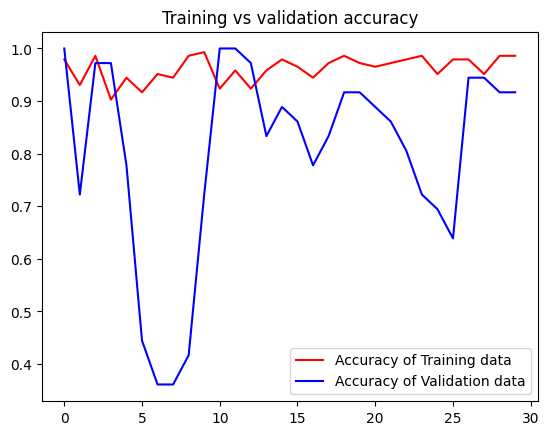

<Figure size 640x480 with 0 Axes>

In [ ]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

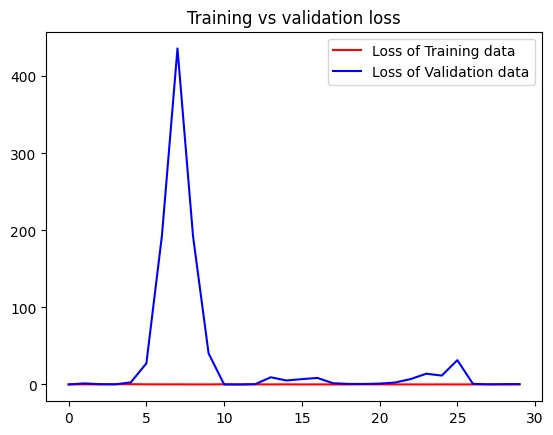

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

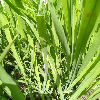

In [ ]:
load_img("/content/drive/MyDrive/dataset/paddy-doctor/train_image/hispa/100003.jpg",target_size=(100,100))

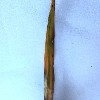

In [ ]:
load_img("/content/drive/MyDrive/dataset/disease/tungro/IMG_1028.jpg",target_size=(100,100))

In [ ]:
image=load_img("/content/drive/MyDrive/dataset/disease/tungro/IMG_1028.jpg",target_size=(100,100))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [ ]:
image=load_img("/content/drive/MyDrive/dataset/paddy-doctor/train_image/hispa/100003.jpg",target_size=(100,100))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [ ]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)

  print(classes[0])
  value=np.argmax(classes)
  move_name=mapper(value)
  
  print("Prediction is {}.".format(move_name))
 

Saving tungro.jpg to tungro.jpg
1/1 [==============================] - 0s 45ms/step
[7.802222e-16 0.000000e+00 1.000000e+00]
Prediction is tungro.


In [ ]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

1/1 [==============================] - 1s 1s/step
Prediction is blight.


In [ ]:
print(test.shape)
prediction2=model.predict(test)
print(prediction2.shape)

PRED=[]
for item in prediction2:
    value2=np.argmax(item)      
    PRED+=[value2]

(60, 100, 100, 3)
2/2 [==============================] - 2s 2s/step
(60, 3)


In [ ]:
ANS=tlabels0

In [ ]:
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.8333333333333334
